## Tiling of full images into overlapping patches

Total number of patches: 506


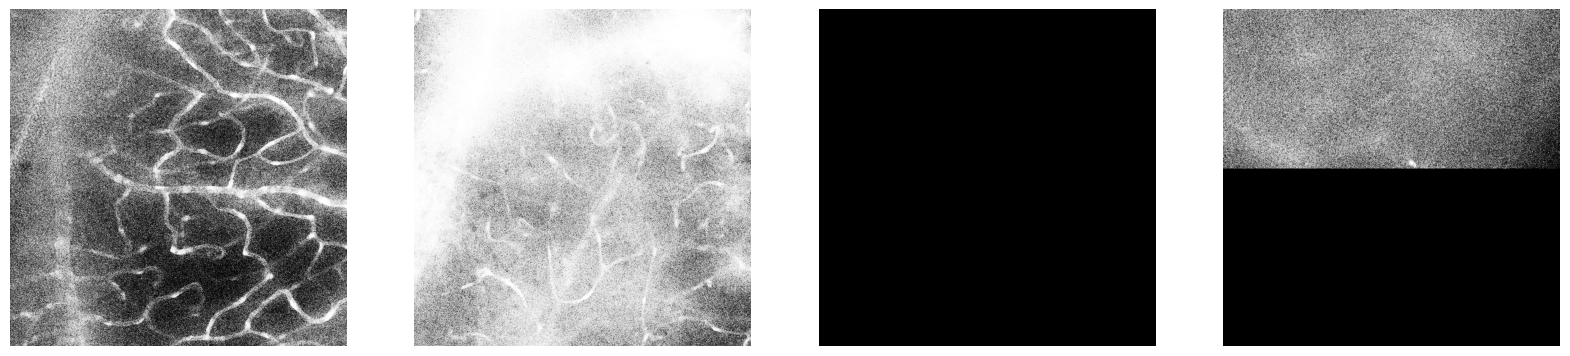

In [50]:
import numpy as np
from PIL import Image
import random
import matplotlib.pyplot as plt
import os
from tifffile import tifffile



def extract_overlapping_patches(image, patch_size=600, overlap=0.3):
    """
    Extracts overlapping patches of a given size from an image.
    
    :param image: Numpy array of the image.
    :param patch_size: The size of the square patches.
    :param overlap: Fraction of the patch size to overlap (e.g., 0.5 for 50% overlap).
    :return: List of image patches.
    """
    stride = int(patch_size * (1 - overlap))
    patches = []
    
    for y in range(0, image.shape[0] - patch_size + 1, stride):
        for x in range(0, image.shape[1] - patch_size + 1, stride):
            patch = image[y:y+patch_size, x:x+patch_size]
            patches.append(patch)
            
    return patches



image_path = "data\PBS\Akita_22_OE_25x_stack_6.tif"

image = tifffile.imread(image_path)



patches = extract_overlapping_patches(image)

print(f"Total number of patches: {len(patches)}")

selected_patches = random.sample(patches, 4)

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for i, patch in enumerate(selected_patches):
    axs[i].imshow(patch, cmap='gray')
    axs[i].axis('off')

plt.show()



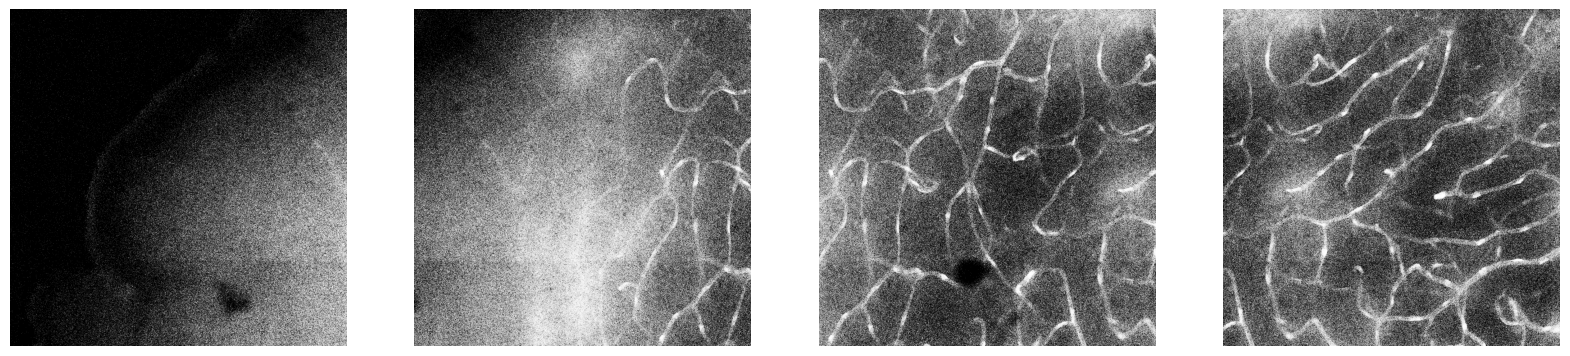

In [52]:
# Select 4 patches
middle_index = len(patches) // 2
selected_patches = patches[middle_index:middle_index+4]

# Create a figure with 4 subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Display each patch
for i, patch in enumerate(selected_patches):
    axs[i].imshow(patch, cmap='gray')
    axs[i].axis('off')

plt.show()


## Cleaning, normalize pixel values

In [70]:
from skimage.restoration import denoise_nl_means, estimate_sigma
import numpy as np

def denoise_patch(patch):
    # Assuming patch is a 2D numpy array (grayscale). For RGB, add the channel dimension as needed.
    sigma_est = np.mean(estimate_sigma(patch))
    patch_kw = dict(patch_size=5,      # 5x5 patches
                    patch_distance=6)  # Search up to 6 pixels away for similar patches
    denoised_patch = denoise_nl_means(patch, h=1.15 * sigma_est, fast_mode=True, **patch_kw)
    return denoised_patch


In [66]:
import numpy as np

def normalize_patch(patch):
    """Normalize image patch to the range [0, 1]."""
    patch_min = patch.min()
    patch_max = patch.max()
    # Check if all pixel values are the same
    if patch_max == patch_min:

        normalized_patch = np.zeros_like(patch)
    else:
        normalized_patch = (patch - patch_min) / (patch_max - patch_min)
    return normalized_patch




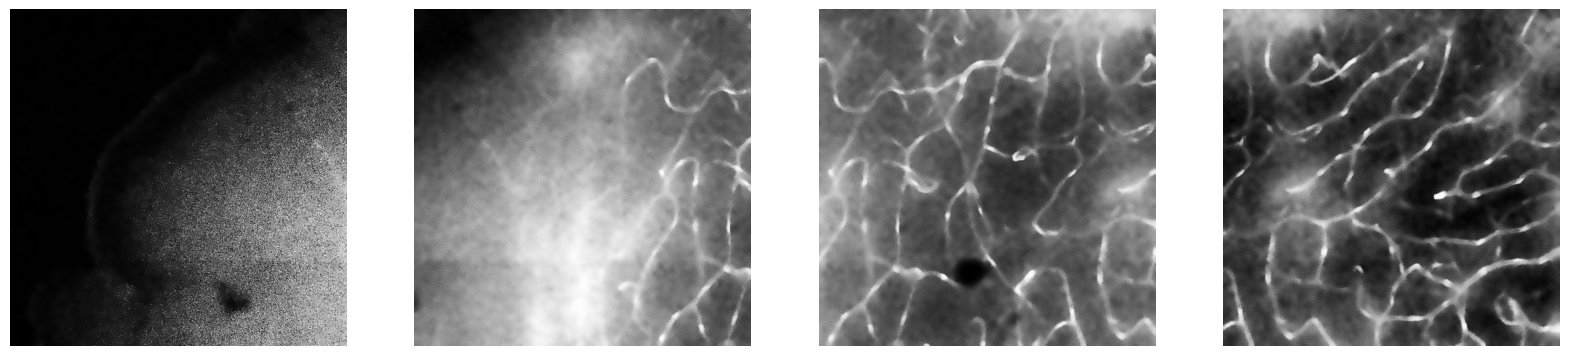

In [71]:
denoised_patches = [denoise_patch(patch) for patch in patches]

# Assuming that the normalize_patch function takes a patch as an argument
normalized_patches = [normalize_patch(patch) for patch in denoised_patches]

# Select 4 patches
middle_index = len(normalized_patches) // 2
selected_patches = normalized_patches[middle_index:middle_index+4]

# Create a figure with 4 subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Display each patch
for i, patch in enumerate(selected_patches):
    axs[i].imshow(patch, cmap='gray')
    axs[i].axis('off')

plt.show()



# Denoise with ML

In [73]:
%pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

UsageError: Line magic function `%pip3` not found.


In [ ]:
from dru_net import DRUNet

model = DRUNet()  # Initialize the model architecture


In [ ]:
model.load_state_dict(torch.load('path_to_your_model.pth'))
model.eval()  # Set the model to evaluation mode


In [ ]:
from torchvision import transforms
from PIL import Image
import torch


# Convert the image to tensor and normalize (adjust normalization parameters as necessary)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

input_tensor = transform(image).unsqueeze(0)  # Add batch dimension


In [ ]:
with torch.no_grad():  # No need to track gradients
    denoised_tensor = model(input_tensor)
